<a href="https://colab.research.google.com/github/davidgabai11111/Final-ML-project/blob/main/Final_ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


In [ ]:
START_DATE = "2015-01-01"
END_DATE   = "2025-02-01"

TICKERS = {
    "MSCI_WORLD":    "URTH",
    "MSCI_EM":       "EEM",
    "SP500":         "SPY",
    "NASDAQ":        "QQQ",
    "DOWJONES":      "DIA",
    "EUROSTOXX50":   "FEZ",
    "CAC40":         "EWQ",
    "DAX":           "EWG",
    "NIKKEI":        "EWJ",
    "GOLD":          "GLD",
    "SILVER":        "SLV",
    "BITCOIN":       "BTC-USD",
}


In [ ]:
raw = yf.download(
    list(TICKERS.values()),
    start=START_DATE,
    end=END_DATE
)

# We use the "Close" column instead of "Adj Close".
close_prices = raw["Close"]

# Rename columns with logical names (SP500, GOLD, BITCOIN, etc.)
mapping = {v: k for k, v in TICKERS.items()}
prices = close_prices.rename(columns=mapping)

prices.tail()


/tmp/ipython-input-1371038326.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(
[*********************100%***********************]  12 of 12 completed


Ticker,BITCOIN,DOWJONES,MSCI_EM,DAX,NIKKEI,CAC40,EUROSTOXX50,GOLD,NASDAQ,SILVER,SP500,MSCI_WORLD
Date,,,,,,,,,,,,
2025-01-27,102087.687500,441.369934,41.765396,33.945503,67.196053,38.277969,51.098244,252.990005,512.274475,27.459999,594.163757,158.757355
2025-01-28,101332.476562,442.643372,42.072422,33.994686,67.761475,37.886879,50.785233,255.179993,519.845886,27.629999,599.268982,159.700089
2025-01-29,103703.210938,441.429169,42.082329,34.171741,67.553162,37.759773,50.902615,254.199997,518.869629,28.000000,596.582581,159.184082
2025-01-30,104735.304688,443.048126,42.795418,34.338959,68.564980,38.062870,51.440586,258.049988,521.081177,28.719999,599.784485,160.315369
2025-01-31,102405.023438,439.662170,42.310123,34.063541,67.761475,37.769550,50.980862,258.559998,520.324036,28.510000,596.592407,159.432175


In [ ]:
from dataclasses import dataclass
from typing import List, Dict
@dataclass
class CFG:
    # Asset universe: index ETFs + gold + silver + bitcoin (Yahoo tickers).
    tickers: List[str] = (
        "URTH",      # MSCI World
        "EEM",       # MSCI Emerging Markets
        "SPY",       # S&P 500
        "QQQ",       # Nasdaq 100
        "DIA",       # Dow Jones
        "FEZ",       # EuroStoxx 50
        "EWQ",       # France (CAC 40)
        "EWG",       # Allemagne (DAX)
        "EWJ",       # Japon (Nikkei)
        "GLD",       # Or
        "SLV",       # Argent
        "BTC-USD",   # Bitcoin
    )
    start: str = "2015-01-01"
    end: str | None = None
    H: int = 21        # Rebalancing horizon & frequency (~1 month)
    top_k: int = 3     # Number of assets selected at each rebalancing
    lookback_min_days: int = 252  # Minimum lookback window before the first training
    transaction_cost_bps: float = 5.0  # Transaction costs (bps)

cfg = CFG()
# ------------------ Utils: Data ------------------

def load_prices_yf(tickers: List[str], start: str, end: str | None) -> pd.DataFrame:
    """
    Download 'Close' prices using yfinance for a list of Yahoo tickers.
    Returns a DataFrame px (index = dates, columns = tickers).
    """
    raw = yf.download(list(tickers), start=start, end=end)
    close = raw["Close"]
    # If a single ticker is returned as a Series, convert it to a DataFrame.
    if isinstance(close, pd.Series):
        close = close.to_frame()
    # Basic cleaning
    px = close.dropna(how="all").sort_index()
    px = px.ffill().dropna()
    return px

def compute_returns(px: pd.DataFrame) -> pd.DataFrame:
    """Daily simple returns (pct_change)."""
    return px.pct_change().dropna()

def build_features(rets: pd.DataFrame) -> pd.DataFrame:
    """
    Build features for each (date, ticker):
    - mom_1m: 1-month momentum (product of (1+r) over 21 days − 1)
    - vol_1m: 1-month volatility (standard deviation of returns over 21 days)
    - rev_1w: 1-week reversal (inverse momentum over 5 days)
    Return a long-format DataFrame: columns = date, ticker, mom_1m, vol_1m, rev_1w.
    """
    # Rolling features computed per column (per ticker).
    mom_1m = (1.0 + rets).rolling(21).apply(np.prod, raw=True) - 1.0
    vol_1m = rets.rolling(21).std()
    rev_1w = -((1.0 + rets).rolling(5).apply(np.prod, raw=True) - 1.0)

    def to_long(df, name):
        return df.stack().rename(name)

    feats = pd.concat([
        to_long(mom_1m, "mom_1m"),
        to_long(vol_1m, "vol_1m"),
        to_long(rev_1w, "rev_1w")
    ], axis=1).reset_index()

    feats.columns = ["date", "ticker", "mom_1m", "vol_1m", "rev_1w"]
    feats = feats.dropna()
    return feats

def future_Hday_return(rets: pd.DataFrame, H: int) -> pd.DataFrame:
    """Future cumulative return over H days (rolling product, then shift by −H)."""
    cum = (1.0 + rets).rolling(H).apply(np.prod, raw=True) - 1.0
    return cum.shift(-H)

def build_ml_dataset(rets: pd.DataFrame) -> pd.DataFrame:
    """
    Build the (X, y) dataset for the ML models from the returns.
    We reuse exactly the same construction as in run_backtest.
    """
    feats = build_features(rets)  # mom_1m, vol_1m, rev_1w

    y_fwd = future_Hday_return(rets, cfg.H)
    y_long = y_fwd.stack().rename("y_reg").reset_index()
    y_long.columns = ["date", "ticker", "y_reg"]

    data = feats.merge(y_long, on=["date", "ticker"], how="inner").dropna()
    data["y_cls"] = (data["y_reg"] > 0.0).astype(int)

    first_allowed = rets.index.min() + pd.tseries.offsets.BDay(cfg.lookback_min_days)
    data = data[data["date"] >= first_allowed]

    return data

In [ ]:
# Load historical prices, compute returns, and build the ML dataset
px = load_prices_yf(list(cfg.tickers), cfg.start, cfg.end)
rets = compute_returns(px)
data_ml = build_ml_dataset(rets)

/tmp/ipython-input-2661595177.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(list(tickers), start=start, end=end)
[*********************100%***********************]  12 of 12 completed


In [ ]:
# Inspect price dataset structure and check for missing values
prices.info()
prices.isna().sum()

# Compute daily returns and display descriptive statistics
returns = prices.pct_change().dropna()
returns.describe().T

# Check for duplicated rows in prices and ML dataset
prices.duplicated().sum()
data_ml.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3684 entries, 2015-01-01 to 2025-01-31
Freq: D
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BITCOIN      3684 non-null   float64
 1   DOWJONES     2536 non-null   float64
 2   MSCI_EM      2536 non-null   float64
 3   DAX          2536 non-null   float64
 4   NIKKEI       2536 non-null   float64
 5   CAC40        2536 non-null   float64
 6   EUROSTOXX50  2536 non-null   float64
 7   GOLD         2536 non-null   float64
 8   NASDAQ       2536 non-null   float64
 9   SILVER       2536 non-null   float64
 10  SP500        2536 non-null   float64
 11  MSCI_WORLD   2536 non-null   float64
dtypes: float64(12)
memory usage: 374.2 KB


/tmp/ipython-input-2516714364.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()


np.int64(0)

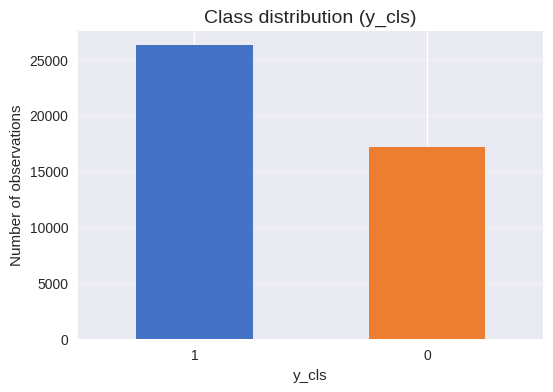

Distribution (proportions) :
y_cls
1    0.605365
0    0.394635
Name: proportion, dtype: float64


In [ ]:
# Balance of classes

# Visualize class distribution of the target variable
plt.figure(figsize=(6,4))
data_ml["y_cls"].value_counts().plot(kind="bar", color=["#4472C4", "#ED7D31"])
plt.title("Class distribution (y_cls)", fontsize=14)
plt.xticks(rotation=0)
plt.ylabel("Number of observations")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Display class proportions
print("Distribution (proportions) :")
print(data_ml["y_cls"].value_counts(normalize=True))


In [ ]:
# Data quality: missing values, duplicates, descriptive statistics

print(" ML dataset dimensions :", data_ml.shape)
print("\n Number of missing values :")
print(data_ml.isna().sum())
print("\n Number of duplicate rows :", data_ml.duplicated().sum())
print("\n Descriptive statistics :")
display(data_ml.describe())

# Outlier analysis using extreme percentiles
print("\n Outlier analysis (1% et 99%) :")
display(data_ml[["mom_1m", "vol_1m", "rev_1w"]].describe(percentiles=[0.01,0.05,0.95,0.99]).T)


 ML dataset dimensions : (43392, 7)

 Number of missing values :
date      0
ticker    0
mom_1m    0
vol_1m    0
rev_1w    0
y_reg     0
y_cls     0
dtype: int64

 Number of duplicate rows : 0

 Descriptive statistics :


,date,mom_1m,vol_1m,rev_1w,y_reg,y_cls
count,43392,43392.000000,43392.000000,43392.000000,43392.000000,43392.000000
mean,2020-12-02 12:00:00,0.010739,0.010853,-0.002522,0.010731,0.605365
min,2015-12-22 00:00:00,-0.496717,0.001250,-0.616284,-0.496717,0.000000
25%,2018-06-12 18:00:00,-0.017471,0.005883,-0.014188,-0.017505,0.000000
50%,2020-12-02 12:00:00,0.009900,0.008178,-0.002505,0.009936,1.000000
75%,2023-05-25 06:00:00,0.033805,0.011851,0.009669,0.033823,1.000000
max,2025-11-14 00:00:00,1.273933,0.106511,0.442108,1.273933,1.000000
std,NaN,0.070568,0.009330,0.031941,0.070631,0.488778



 Outlier analysis (1% et 99%) :


,count,mean,std,min,1%,5%,50%,95%,99%,max
mom_1m,43392.0,0.010739,0.070568,-0.496717,-0.171452,-0.075380,0.009900,0.092910,0.263893,1.273933
vol_1m,43392.0,0.010853,0.009330,0.001250,0.002686,0.003621,0.008178,0.029446,0.051381,0.106511
rev_1w,43392.0,-0.002522,0.031941,-0.616284,-0.104397,-0.043016,-0.002505,0.038846,0.090957,0.442108


In [ ]:
# Clean missing data: remove empty rows, forward-fill, then drop remaining NaNs
prices = prices.dropna(how="all")
prices = prices.ffill()
prices = prices.dropna()

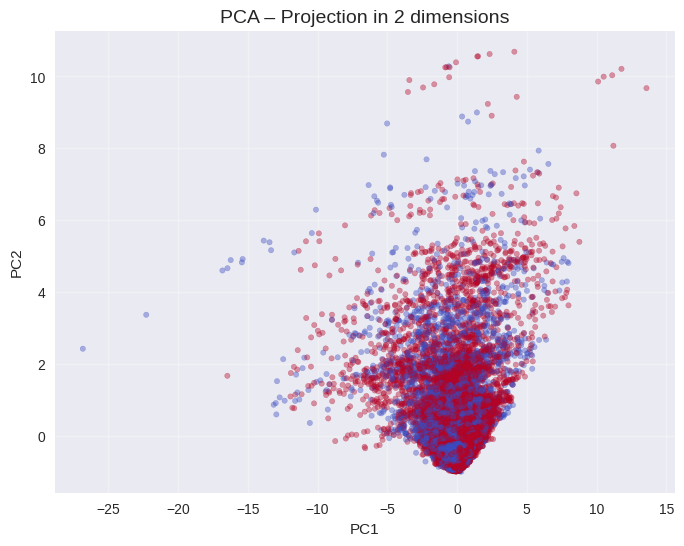

Variance expliquée par PC1 + PC2 : 0.8337520467128365


In [ ]:
# PCA (2 components)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = data_ml[["mom_1m","vol_1m","rev_1w"]].values
y = data_ml["y_cls"].values

# Standardization before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA in 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="coolwarm", alpha=0.4, s=15)
plt.title("PCA – Projection in 2 dimensions", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.show()

print("Variance explained by PC1 + PC2 :", pca.explained_variance_ratio_.sum())


In [ ]:
# Statistical analysis of returns
returns = prices.pct_change().dropna()
print(" Return statistics (annualized) :")

daily = returns
annualized = pd.DataFrame({
    "mean_ann": daily.mean() * 252,
    "vol_ann": daily.std() * np.sqrt(252),
    "skewness": daily.skew(),
    "kurtosis": daily.kurt()
})

display(annualized.sort_values("vol_ann"))


 Return statistics (annualized) :


,mean_ann,vol_ann,skewness,kurtosis
Ticker,,,,
GOLD,0.062866,0.117123,-0.083958,5.306185
NIKKEI,0.050198,0.142044,-0.554919,10.075549
MSCI_WORLD,0.078584,0.143196,-0.923496,23.122912
DOWJONES,0.087568,0.144587,-0.679643,31.320076
SP500,0.096202,0.146012,-0.610982,19.761464
MSCI_EM,0.036491,0.171249,-0.624048,12.651818
CAC40,0.064153,0.173383,-1.039585,20.230958
DAX,0.048478,0.175384,-0.765272,17.664511
EUROSTOXX50,0.058922,0.175747,-1.007443,18.580133


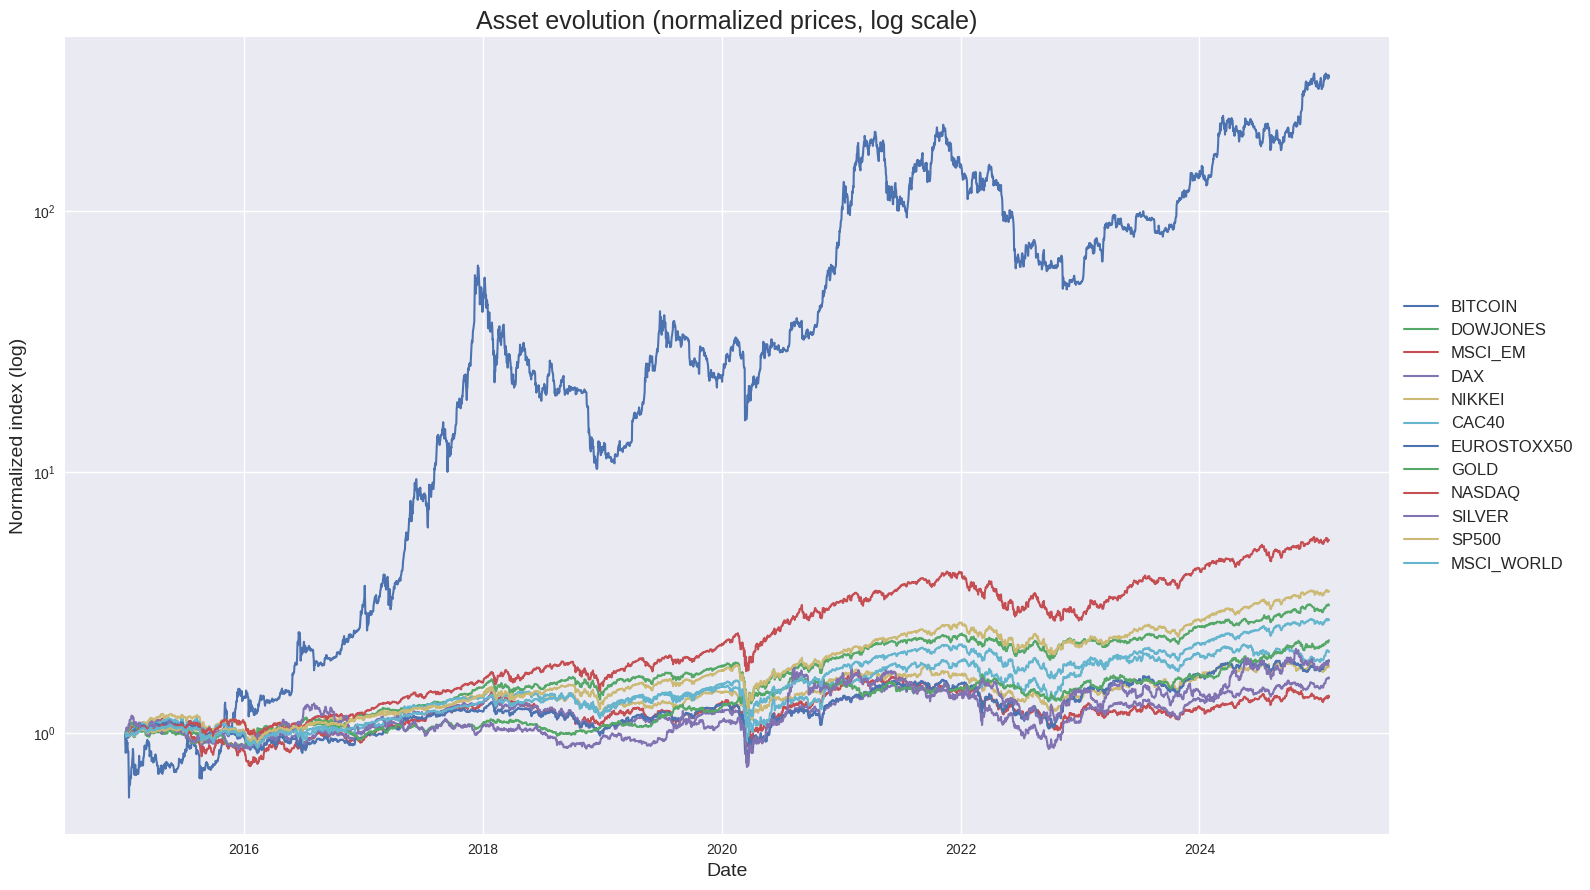

In [ ]:
norm = prices / prices.iloc[0]

plt.figure(figsize=(16,9))

for col in norm.columns:
    plt.plot(norm.index, norm[col], label=col, linewidth=1.5)

plt.yscale("log")  # Logarithmic scale

plt.title("Asset evolution (normalized prices, log scale)", fontsize=18)
plt.ylabel("Normalized index (log)", fontsize=14)
plt.xlabel("Date", fontsize=14)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
plt.tight_layout()
plt.show()


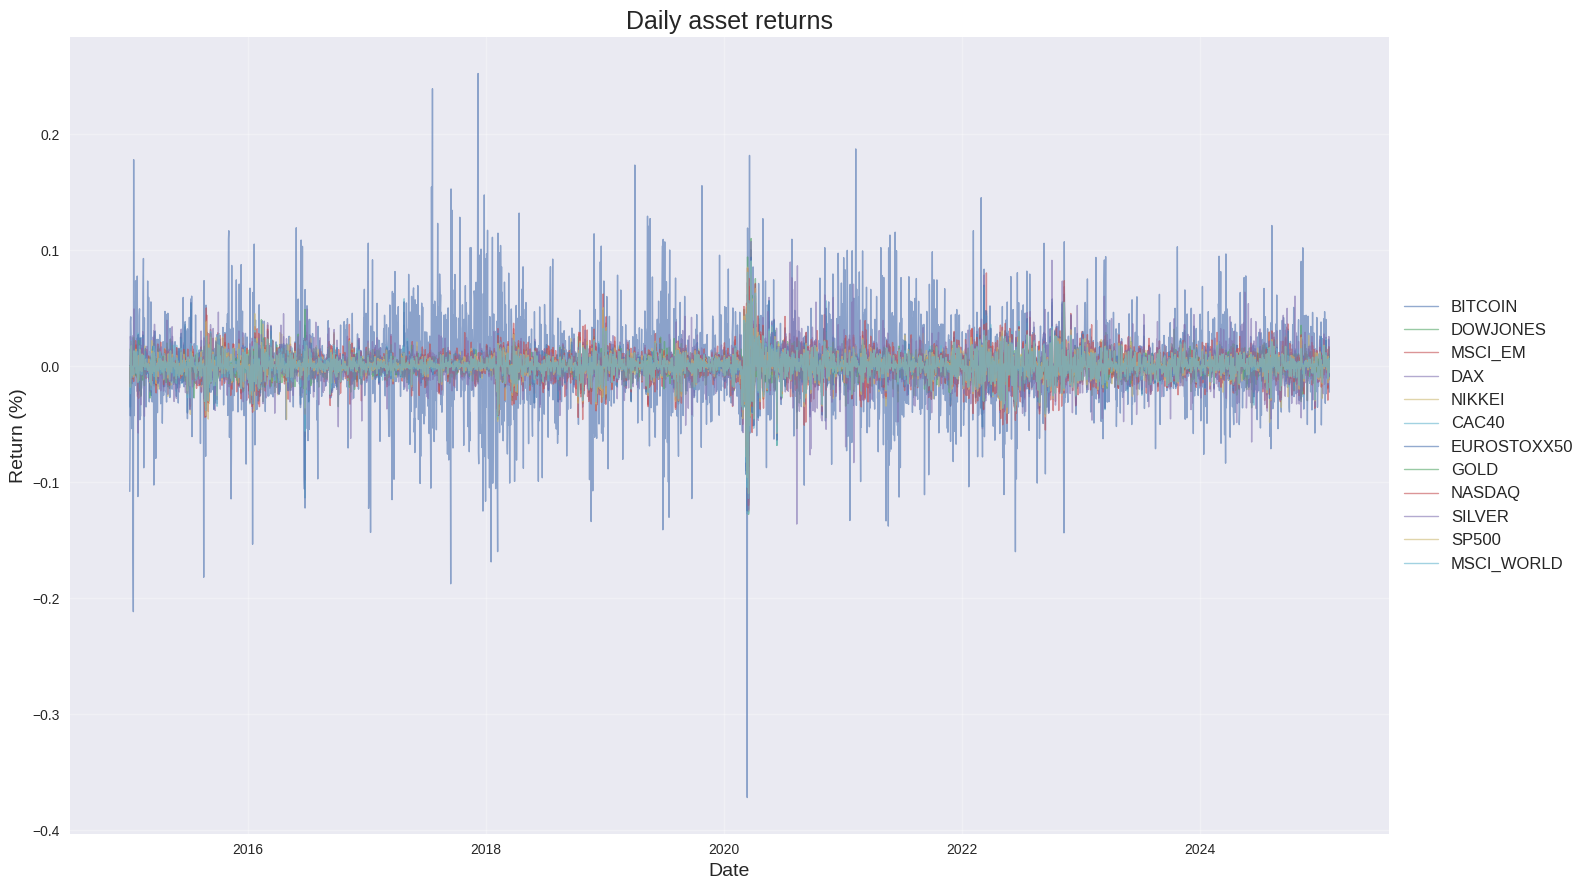

In [ ]:
returns = prices.pct_change().dropna()

plt.figure(figsize=(16,9))

for col in returns.columns:
    plt.plot(returns.index, returns[col], alpha=0.6, linewidth=1, label=col)

plt.title("Daily asset returns", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Return (%)", fontsize=14)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


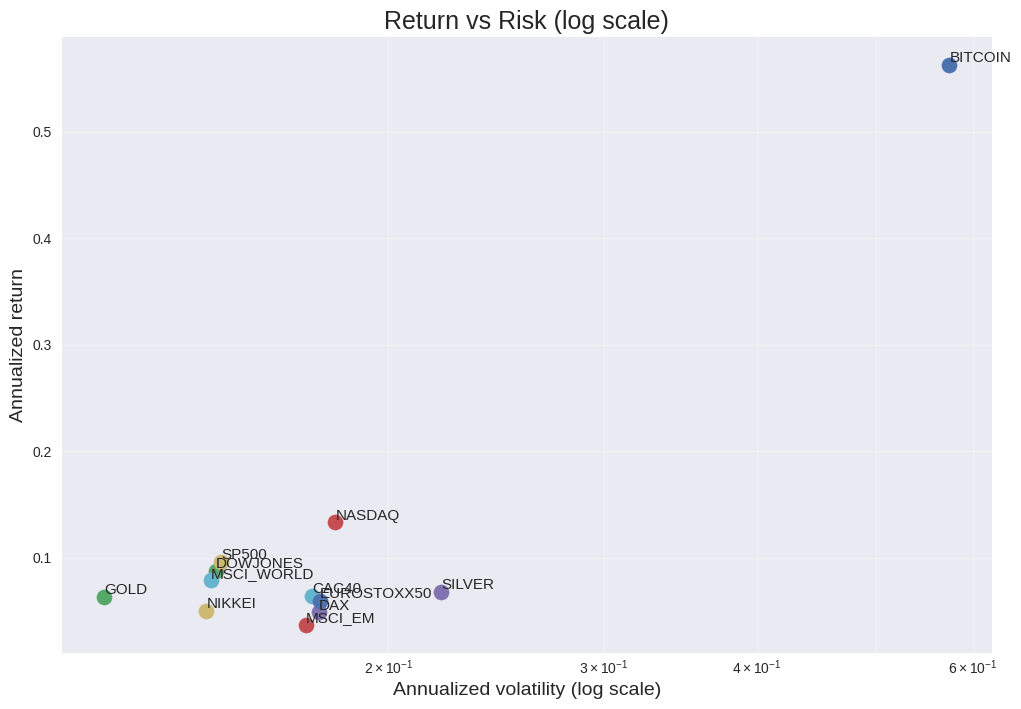

In [ ]:
plt.figure(figsize=(12,8))
# Daily returns
daily_ret = prices.pct_change().dropna()

# Annualized return by asset
ann_ret = daily_ret.mean() * 252      # Another annualization formula

# Annualized volatility by asset
ann_vol = daily_ret.std() * np.sqrt(252)

for asset in ann_ret.index:
    plt.scatter(ann_vol[asset], ann_ret[asset], s=120)
    plt.text(
        ann_vol[asset],
        ann_ret[asset],
        asset,
        fontsize=11,
        ha='left',
        va='bottom'
    )

plt.xscale("log")  # Log scale for volatility

plt.xlabel("Annualized volatility (log scale)", fontsize=14)
plt.ylabel("Annualized return", fontsize=14)
plt.title("Return vs Risk (log scale)", fontsize=18)
plt.grid(alpha=0.3, which="both")
plt.show()


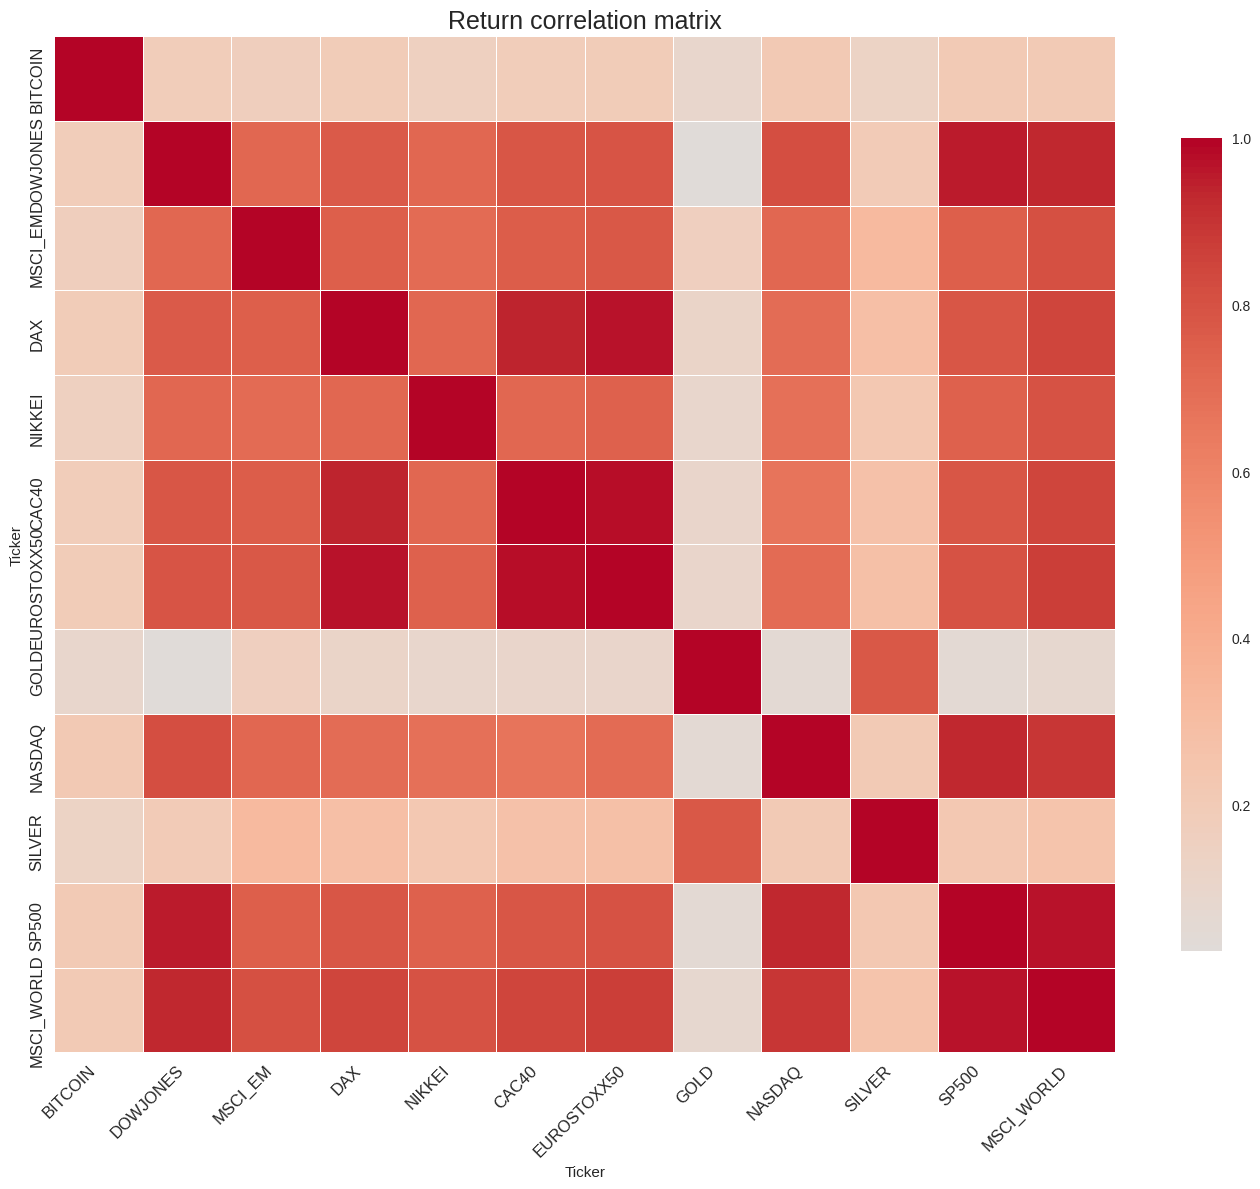

In [ ]:
corr = returns.corr()

plt.figure(figsize=(14,12))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=False,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Return correlation matrix", fontsize=18)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import io
import math
from dataclasses import dataclass
from typing import List, Dict

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# XGBoost
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None  # we handle the case where it is not installed

# LightGBM
try:
    from lightgbm import LGBMClassifier
except ImportError:
    LGBMClassifier = None

# Utils: Metrics
# Metrics are computed on daily return series / equity curves to evaluate the strategies.
def sharpe_ratio(daily_rets: pd.Series, freq: int = 252) -> float:
    # Annualized Sharpe ratio assuming 'freq' trading days per year (default: 252)
    mu = daily_rets.mean()
    sd = daily_rets.std(ddof=1)
    return np.nan if sd == 0 or np.isnan(sd) else (mu / sd) * math.sqrt(freq)

def cagr_from_equity(eq: pd.Series, trading_days: int = 252) -> float:
    # CAGR computed from an equity curve (cumprod of 1+returns)
    eq = eq.dropna()
    if len(eq) < 2:
        return np.nan
    years = len(eq) / trading_days
    return (eq.iloc[-1] / eq.iloc[0])**(1 / years) - 1

def max_drawdown(eq: pd.Series) -> float:
    # Maximum drawdown: worst peak-to-trough decline of the equity curve
    peak = eq.cummax()
    dd = eq / peak - 1.0
    return dd.min()

# Main Backtest (for a given top_k)

# At each rebalancing date:
# Train the ML model on STRICTLY past data (no look-ahead bias)
# Predict scores for the current date
# Buy the top_k assets and hold for H days (with transaction costs)

def run_backtest(px: pd.DataFrame, rets: pd.DataFrame, top_k: int, model_type: str):
    """
    Multi-asset backtest using an ML model re-trained at each date
    only on PAST data (no look-ahead bias).

    model_type: "logreg", "svm" or "rf"
    """

    # 1) Features + Targets
    feats = build_features(rets)
    y_fwd = future_Hday_return(rets, cfg.H)
    y_long = y_fwd.stack().rename("y_reg").reset_index()
    y_long.columns = ["date", "ticker", "y_reg"]

    data = feats.merge(y_long, on=["date", "ticker"], how="inner").dropna()
    data["y_cls"] = (data["y_reg"] > 0.0).astype(int)

    # Enforce a minimum lookback window to avoid training on too few data points
    first_allowed = rets.index.min() + pd.tseries.offsets.BDay(cfg.lookback_min_days)
    data = data[data["date"] >= first_allowed]

    dates = sorted(data["date"].unique())
    if len(dates) == 0:
        raise RuntimeError("Not enough data after lookback.")

    # Rebalancing dates (every H days)
    rebal_dates = dates[::cfg.H]
    tickers = list(px.columns)

    # Daily return series for the strategy
    daily_idx = rets.index
    ret_topk = pd.Series(0.0, index=daily_idx, name="TOPK")
    ret_equal = pd.Series(0.0, index=daily_idx, name="EQUAL")

    # Store which assets are selected at each rebalance (for interpretability)
    selection_history = []

    for d in rebal_dates:
        # Time split: train = strict past, test_today = current date
        train = data[data["date"] < d]
        test_today = data[data["date"] == d]

        # Skip if not enough history or no data on that day
        if len(train) < 200 or test_today.empty:
            continue

        X_tr = train[["mom_1m", "vol_1m", "rev_1w"]].values
        y_tr = train["y_cls"].values
        X_te = test_today[["mom_1m", "vol_1m", "rev_1w"]].values

        # ML model training
        if model_type == "logreg":
            # Linear baseline with scaling + class balance handling
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", LogisticRegression(
                    max_iter=400,
                    class_weight="balanced",
                    random_state=0
                ))
            ])
            pipe.fit(X_tr, y_tr)
            ppos = pipe.predict_proba(X_te)[:, 1]

        elif model_type == "svm":
            # Non-linear classifier; probability=True enables predict_proba (slower but useful)
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", SVC(
                    C=2.0,
                    kernel="rbf",
                    gamma="scale",
                    probability=True,
                    random_state=0
                ))
            ])
            pipe.fit(X_tr, y_tr)
            ppos = pipe.predict_proba(X_te)[:, 1]

        elif model_type == "rf":
            # Tree ensemble baseline (no scaling needed)
            mdl = RandomForestClassifier(
                n_estimators=200,
                max_depth=6,
                min_samples_split=10,
                min_samples_leaf=4,
                n_jobs=-1,
                random_state=0
            )
            mdl.fit(X_tr, y_tr)
            ppos = mdl.predict_proba(X_te)[:, 1]

        else:
            raise ValueError(f"model_type inconnu : {model_type}")

        preds = pd.Series(ppos, index=test_today["ticker"].values)

        # Selection of top_k assets
        top = preds.sort_values(ascending=False).head(top_k).index.tolist()

        # Portfolio weights: equal weight among selected assets
        w_topk = pd.Series(0.0, index=tickers)
        if len(top) > 0:
            w_topk.loc[top] = 1.0 / len(top)

        # Equal-weight portfolio (benchmark)
        w_equal = pd.Series(1.0 / len(tickers), index=tickers)

        selection_history.append({
            "date": d,
            "top_k": top_k,
            "selected_tickers": ",".join(top),
        })

        # Execution window between d+1 and d+H
        if d in rets.index:
            start_ix = rets.index.get_loc(d) + 1
        else:
            start_ix = rets.index.searchsorted(pd.Timestamp(d))
        end_ix = min(start_ix + cfg.H, len(rets.index))
        if start_ix >= len(rets.index):
            continue

        idx = rets.index[start_ix:end_ix]
        r = rets.loc[idx]

        # Transaction costs at the beginning of each period
        tc = cfg.transaction_cost_bps / 1e4
        if len(idx) > 0:
            ret_topk.loc[idx[0]] -= tc * np.abs(w_topk).sum()
            ret_equal.loc[idx[0]] -= tc * np.abs(w_equal).sum()

        # Daily returns weighted by portfolio weights
        ret_topk.loc[idx] = (r * w_topk).sum(axis=1).values + ret_topk.loc[idx]
        ret_equal.loc[idx] = (r * w_equal).sum(axis=1).values + ret_equal.loc[idx]

    # Combine strategy and benchmark into one DataFrame
    df = pd.concat([ret_topk, ret_equal], axis=1).fillna(0.0)

    # Compute performance metrics for each series
    metrics = []
    for name in ["TOPK", "EQUAL"]:
        rr = df[name]
        eq = (1.0 + rr).cumprod()
        metrics.append([
            name,
            sharpe_ratio(rr),
            cagr_from_equity(eq),
            max_drawdown(eq)
        ])
    met = pd.DataFrame(
        metrics,
        columns=["strategy", "sharpe", "cagr", "max_drawdown"]
    ).set_index("strategy")

    sel = pd.DataFrame(selection_history).sort_values("date")

    return df, met, sel

# Baseline ML models (hold-out evaluation)
# Purpose: compare standard classifiers on the constructed dataset (F1 as main metric).
# Note: we optionally subsample the dataset to speed up GridSearch in notebooks.

def gridsearch_baseline_models(data: pd.DataFrame):
    """
    Extended version:
    - Global subsampling for speed
    - GridSearch on LogisticRegression (baseline)
    - SVM, DecisionTree, RandomForest, XGBoost, LightGBM with fixed hyperparameters
    - Also returns the name of the best model (based on F1)
    """

    # 0) Global subsampling
    # We limit dataset size for fast iteration in notebooks
    MAX_SAMPLES = 5000
    if len(data) > MAX_SAMPLES:
        data = data.sample(n=MAX_SAMPLES, random_state=0)

    # Feature matrix and binary label
    X = data[["mom_1m", "vol_1m", "rev_1w"]].values
    y = data["y_cls"].values

    # Stratified split to preserve class proportions
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0, stratify=y
    )

    best_models = {}
    rows = []

    # 1) Logistic Regression with small GridSearch
    logreg_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=300,
            class_weight="balanced",
            random_state=0
        ))
    ])

    logreg_grid = {
        "clf__C": [0.1, 1.0, 10.0],
    }

    # Cross-validation score uses F1 (more appropriate than accuracy under imbalance)
    print("\n=== GridSearch for Logistic Regression ===")
    gs = GridSearchCV(
        estimator=logreg_pipe,
        param_grid=logreg_grid,
        scoring="f1",
        cv=2,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)

    best_logreg = gs.best_estimator_
    best_models["logreg"] = best_logreg

    # Evaluate on held-out test set
    y_pred_log = best_logreg.predict(X_test)
    acc_log = accuracy_score(y_test, y_pred_log)
    f1_log = f1_score(y_test, y_pred_log)

    rows.append({
        "model": "logreg",
        "cv_f1_mean": gs.best_score_,
        "test_accuracy": acc_log,
        "test_f1": f1_log
    })

    print("Best hyperparameters (LogReg) :", gs.best_params_)
    print("Mean CV score (F1)  :", gs.best_score_)
    print("Accuracy test        :", acc_log)
    print("F1 test              :", f1_log)

    # 2) Fixed SVM
    # (kept fixed to avoid heavy grid-search; scaling is mandatory for SVM)
    svm_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(C=2.0, kernel="rbf", gamma="scale", random_state=0))
    ])
    svm_pipe.fit(X_train, y_train)
    y_pred_svm = svm_pipe.predict(X_test)
    acc_svm = accuracy_score(y_test, y_pred_svm)
    f1_svm = f1_score(y_test, y_pred_svm)

    best_models["svm"] = svm_pipe
    rows.append({
        "model": "svm_fixed",
        "cv_f1_mean": np.nan,
        "test_accuracy": acc_svm,
        "test_f1": f1_svm
    })

    # 3) Fixed Decision Tree (interpretable, fast)
    tree_clf = DecisionTreeClassifier(
        criterion="gini",
        max_depth=5,
        min_samples_split=20,
        min_samples_leaf=5,
        random_state=0
    )
    tree_clf.fit(X_train, y_train)
    y_pred_tree = tree_clf.predict(X_test)
    acc_tree = accuracy_score(y_test, y_pred_tree)
    f1_tree = f1_score(y_test, y_pred_tree)

    best_models["tree"] = tree_clf
    rows.append({
        "model": "tree_fixed",
        "cv_f1_mean": np.nan,
        "test_accuracy": acc_tree,
        "test_f1": f1_tree
    })

    # 4) Random Forest (robust non-linear model)
    rf_clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=4,
        n_jobs=-1,
        random_state=0
    )
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    f1_rf = f1_score(y_test, y_pred_rf)

    best_models["rf"] = rf_clf
    rows.append({
        "model": "random_forest",
        "cv_f1_mean": np.nan,
        "test_accuracy": acc_rf,
        "test_f1": f1_rf
    })

    # 5) XGBoost (if available)
    if XGBClassifier is not None:
        xgb_clf = XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            n_jobs=-1,
            random_state=0,
            eval_metric="logloss"
        )
        xgb_clf.fit(X_train, y_train)
        y_pred_xgb = xgb_clf.predict(X_test)
        acc_xgb = accuracy_score(y_test, y_pred_xgb)
        f1_xgb = f1_score(y_test, y_pred_xgb)

        best_models["xgb"] = xgb_clf
        rows.append({
            "model": "xgboost",
            "cv_f1_mean": np.nan,
            "test_accuracy": acc_xgb,
            "test_f1": f1_xgb
        })
    else:
        print("XGBoost not installed, XGB model ignored.")

    # 6) LightGBM (if available)
    if LGBMClassifier is not None:
        lgbm_clf = LGBMClassifier(
            n_estimators=300,
            max_depth=-1,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary",
            random_state=0,
            n_jobs=-1
        )
        lgbm_clf.fit(X_train, y_train)
        y_pred_lgbm = lgbm_clf.predict(X_test)
        acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
        f1_lgbm = f1_score(y_test, y_pred_lgbm)

        best_models["lgbm"] = lgbm_clf
        rows.append({
            "model": "lightgbm",
            "cv_f1_mean": np.nan,
            "test_accuracy": acc_lgbm,
            "test_f1": f1_lgbm
        })
    else:
        print("LightGBM not installed, LGBM model ignored.")

    # --------- 7) Summary + best model choice ---------
    summary = pd.DataFrame(rows).set_index("model")
    #print("\n=== Extended baselines summary ===")
    #print(summary)

    # Choose the model with best test F1
    best_model_name = summary["test_f1"].idxmax()
    #print(f"\n>>> Best model (on test F1): {best_model_name}")

    return best_models, summary, (X_train, X_test, y_train, y_test), best_model_name

def ensemble_models_on_project(best_models, data_splits):
    """
    Build and evaluate:
    - Bagging Decision Tree
    - Voting(LogReg + Bagging Tree)

    Uses the same train/test split as for baselines.
    """

    (X_train, X_test, y_train, y_test) = data_splits

    best_logreg = best_models.get("logreg", None)
    best_tree = best_models.get("tree", None)

    if best_logreg is None or best_tree is None:
        print("Need logreg and tree in best_models to build ensembles.")
        return

    # Bagging Decision Tree (fast)
    bag_tree = BaggingClassifier(
        estimator=best_tree,
        n_estimators=15,   # small number of trees
        max_samples=0.8,
        n_jobs=-1,
        random_state=0
    )

    # VotingClassifier (soft) : LogReg + Bagging Tree
    voting_clf = VotingClassifier(
        estimators=[
            ("logreg", best_logreg),
            ("bag_tree", bag_tree),
        ],
        voting="soft"
    )

    models = {
        "Bagging_Tree": bag_tree,
        "Voting_LogReg_BagTree": voting_clf
    }

    rows = []

    for name, mdl in models.items():
        print(f"\n=== Training {name} ===")
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        print("Accuracy test :", acc)
        print("F1 test       :", f1)
        print("Confusion matrix :\n", cm)

        rows.append({
            "model": name,
            "test_accuracy": acc,
            "test_f1": f1
        })

    df_ens = pd.DataFrame(rows).set_index("model")
    print("\n=== Ensembles Summary ===")
    print(df_ens)

    plt.figure(figsize=(6,4))
    df_ens["test_accuracy"].plot(kind="bar")
    plt.ylabel("Accuracy test")
    plt.title("Comparison of ensembles on the project dataset")
    plt.tight_layout()
    plt.show()

    return df_ens

# Main: grid search over k

def main():
    # 1) Data (done only once)
    px = load_prices_yf(list(cfg.tickers), cfg.start, cfg.end)
    rets = compute_returns(px)

    print("\n##############################")
    print("#   PART II: ML on project  #")
    print("##############################\n")

    # Dataset ML (features + y_cls)
    data_ml = build_ml_dataset(rets)

    # Extended baselines : LogReg, SVM, Tree, RF, XGB, LGBM
    best_models, summary_baselines, data_splits, best_model_name = gridsearch_baseline_models(data_ml)
    print("\n=== Baselines summary ===")
    print(summary_baselines)
    print(f"\n>>> Best model (on test F1) : {best_model_name}")

    # Map baseline model name to a "family" for backtest
    # (simplification: XGB/LGBM/Tree -> RF-like for backtest)
    backtest_name_map = {
        "logreg": "logreg",
        "svm_fixed": "svm",
        "tree_fixed": "rf",
        "random_forest": "rf",
        "xgboost": "rf",
        "lightgbm": "rf",
    }

    model_type = backtest_name_map[best_model_name]
    print(f"Model used in the backtest (family) : {model_type}")

    # summary_ensembles = ensemble_models_on_project(best_models, data_splits)

    # REALISTIC BACKTEST (re-training at each date, only on the past)
    results = []
    best_k = None
    best_score = -np.inf
    best_df = None
    best_met = None
    best_sel = None

    print("\n##############################")
    print("#     BACKTEST TOP-K (ML)    #")
    print("##############################\n")

    for k in range(1, 6):
        print(f"\n--- Backtest for top_k = {k} ---")
        df_k, met_k, sel_k = run_backtest(px, rets, top_k=k, model_type=model_type)
        print(met_k)

        score = met_k.loc["TOPK", "sharpe"]
        results.append({
            "k": k,
            "sharpe_TOPK": score,
            "cagr_TOPK": met_k.loc["TOPK", "cagr"],
            "maxdd_TOPK": met_k.loc["TOPK", "max_drawdown"]
        })

        if score > best_score:
            best_score = score
            best_k = k
            best_df = df_k
            best_met = met_k
            best_sel = sel_k

    res_table = pd.DataFrame(results).set_index("k")
    pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

    print("\n=== Summary of results by k (TOPK strategy, realistic backtest) ===")
    print(res_table)

    print(f"\n>>> Best k (on TOPK Sharpe): {best_k}")
    print("\nMetrics for this best k:")
    print(best_met)
    print("\nPreview of selected assets for the best k:")
    print(best_sel.head(10))

    # Save only for best k
    best_df.to_csv(f"simple_perf_series_k{best_k}.csv")
    best_met.to_csv(f"simple_metrics_k{best_k}.csv")
    best_sel.to_csv(f"selected_assets_k{best_k}.csv", index=False)
    print(f"\nSaved: simple_perf_series_k{best_k}.csv")
    print(f"Saved: simple_metrics_k{best_k}.csv")
    print(f"Saved: selected_assets_k{best_k}.csv  (assets chosen at each rebalancing)")




if __name__ == "__main__":
    main()

/tmp/ipython-input-2661595177.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(list(tickers), start=start, end=end)
[*********************100%***********************]  12 of 12 completed



##############################
#   PART II: ML on project  #
##############################


=== GridSearch for Logistic Regression ===
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best hyperparameters (LogReg) : {'clf__C': 10.0}
Mean CV score (F1)  : 0.5081839071865097
Accuracy test        : 0.468
F1 test              : 0.4515463917525773
[LightGBM] [Info] Number of positive: 2424, number of negative: 1576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.606000 -> initscore=0.430529
[LightGBM] [Info] Start training from score 0.430529


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Baselines summary ===
               cv_f1_mean  test_accuracy  test_f1
model                                            
logreg             0.5082         0.4680   0.4515
svm_fixed             NaN         0.6090   0.7533
tree_fixed            NaN         0.5930   0.7403
random_forest         NaN         0.6100   0.7556
xgboost               NaN         0.6000   0.7361
lightgbm              NaN         0.5790   0.6929

>>> Best model (on test F1) : random_forest
Model used in the backtest (family) : rf

##############################
#     BACKTEST TOP-K (ML)    #
##############################


--- Backtest for top_k = 1 ---
          sharpe   cagr  max_drawdown
strategy                             
TOPK      0.5469 0.1252       -0.5184
EQUAL     0.8503 0.1094       -0.3208

--- Backtest for top_k = 2 ---
          sharpe   cagr  max_drawdown
strategy                             
TOPK      0.7505 0.1411       -0.4332
EQUAL     0.8503 0.1094       -0.3208

--- Backtest for top_k 

/tmp/ipython-input-2661595177.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(list(tickers), start=start, end=end)
[*********************100%***********************]  12 of 12 completed



=== GridSearch for Logistic Regression ===
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best hyperparameters (LogReg) : {'clf__C': 1.0}
Mean CV score (F1)  : 0.5074478752422866
Accuracy test        : 0.459
F1 test              : 0.45845845845845845
[LightGBM] [Info] Number of positive: 2423, number of negative: 1577
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.605750 -> initscore=0.429482
[LightGBM] [Info] Start training from score 0.429482

=== Training Bagging_Tree ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy test : 0.603
F1 test       : 0.7510971786833855
Confusion matrix :
 [[  4 390]
 [  7 599]]

=== Training Voting_LogReg_BagTree ===
Accuracy test : 0.605
F1 test       : 0.7523510971786834
Confusion matrix :
 [[  5 389]
 [  6 600]]

=== Ensembles Summary ===
                       test_accuracy  test_f1
model                                        
Bagging_Tree                  0.6030   0.7511
Voting_LogReg_BagTree         0.6050   0.7524


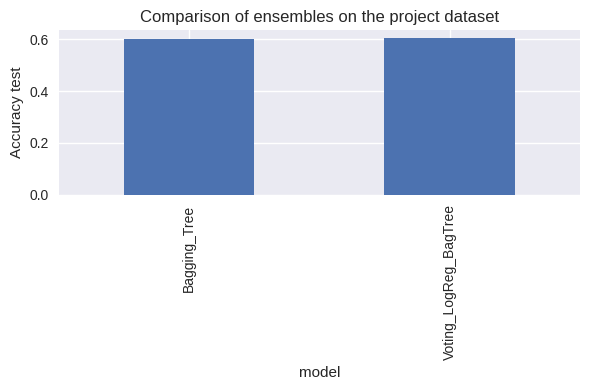

,test_accuracy,test_f1
model,,
Bagging_Tree,0.6030,0.7511
Voting_LogReg_BagTree,0.6050,0.7524


In [ ]:
# 1) Load the data
px = load_prices_yf(list(cfg.tickers), cfg.start, cfg.end)
rets = compute_returns(px)
data_ml = build_ml_dataset(rets)

# 2) Rerun the baseline benchmark
best_models, summary_baselines, data_splits, best_model_name = gridsearch_baseline_models(data_ml)

# 3) Test the ensemble models
df_ens = ensemble_models_on_project(best_models, data_splits)
df_ens


In [ ]:
# NOTE: This cell contains the SAME pipeline as the full-period version,
# but restricted to a shorter time window (2021–2024) to run faster / compare stability.
# The only change is the date filtering in main(); all functions/models/backtest logic remain identical.
import io
import math
from dataclasses import dataclass
from typing import List, Dict

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# XGBoost
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None  # we handle the case where it is not installed


# LightGBM
try:
    from lightgbm import LGBMClassifier
except ImportError:
    LGBMClassifier = None

# Utils: Metrics

def sharpe_ratio(daily_rets: pd.Series, freq: int = 252) -> float:
    mu = daily_rets.mean()
    sd = daily_rets.std(ddof=1)
    return np.nan if sd == 0 or np.isnan(sd) else (mu / sd) * math.sqrt(freq)

def cagr_from_equity(eq: pd.Series, trading_days: int = 252) -> float:
    eq = eq.dropna()
    if len(eq) < 2:
        return np.nan
    years = len(eq) / trading_days
    return (eq.iloc[-1] / eq.iloc[0])**(1 / years) - 1

def max_drawdown(eq: pd.Series) -> float:
    peak = eq.cummax()
    dd = eq / peak - 1.0
    return dd.min()

# Main Backtest (for a given top_k)

def run_backtest(px: pd.DataFrame, rets: pd.DataFrame, top_k: int, model_type: str):
    """
    Multi-asset backtest using an ML model re-trained at each date
    only on PAST data (no look-ahead bias).

    model_type: "logreg", "svm" or "rf"
    """

    # 1) Features + Targets
    feats = build_features(rets)
    y_fwd = future_Hday_return(rets, cfg.H)
    y_long = y_fwd.stack().rename("y_reg").reset_index()
    y_long.columns = ["date", "ticker", "y_reg"]

    data = feats.merge(y_long, on=["date", "ticker"], how="inner").dropna()
    data["y_cls"] = (data["y_reg"] > 0.0).astype(int)

    # Enforce a minimum lookback window to avoid training on too few data points
    first_allowed = rets.index.min() + pd.tseries.offsets.BDay(cfg.lookback_min_days)
    data = data[data["date"] >= first_allowed]

    dates = sorted(data["date"].unique())
    if len(dates) == 0:
        raise RuntimeError("Not enough data after lookback.")

    # Rebalancing dates (every H days)
    rebal_dates = dates[::cfg.H]
    tickers = list(px.columns)

    # Daily return series for the strategy
    daily_idx = rets.index
    ret_topk = pd.Series(0.0, index=daily_idx, name="TOPK")
    ret_equal = pd.Series(0.0, index=daily_idx, name="EQUAL")

    selection_history = []

    for d in rebal_dates:
        # Time split: train = strict past, test_today = current date
        train = data[data["date"] < d]
        test_today = data[data["date"] == d]

        # Skip if not enough history or no data on that day
        if len(train) < 200 or test_today.empty:
            continue

        X_tr = train[["mom_1m", "vol_1m", "rev_1w"]].values
        y_tr = train["y_cls"].values
        X_te = test_today[["mom_1m", "vol_1m", "rev_1w"]].values

        # ML model training
        if model_type == "logreg":
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", LogisticRegression(
                    max_iter=400,
                    class_weight="balanced",
                    random_state=0
                ))
            ])
            pipe.fit(X_tr, y_tr)
            ppos = pipe.predict_proba(X_te)[:, 1]

        elif model_type == "svm":
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", SVC(
                    C=2.0,
                    kernel="rbf",
                    gamma="scale",
                    probability=True,
                    random_state=0
                ))
            ])
            pipe.fit(X_tr, y_tr)
            ppos = pipe.predict_proba(X_te)[:, 1]

        elif model_type == "rf":
            mdl = RandomForestClassifier(
                n_estimators=200,
                max_depth=6,
                min_samples_split=10,
                min_samples_leaf=4,
                n_jobs=-1,
                random_state=0
            )
            mdl.fit(X_tr, y_tr)
            ppos = mdl.predict_proba(X_te)[:, 1]

        else:
            raise ValueError(f"model_type inconnu : {model_type}")

        preds = pd.Series(ppos, index=test_today["ticker"].values)

        # Selection of top_k assets
        top = preds.sort_values(ascending=False).head(top_k).index.tolist()
        w_topk = pd.Series(0.0, index=tickers)
        if len(top) > 0:
            w_topk.loc[top] = 1.0 / len(top)

        # Equal-weight portfolio (benchmark)
        w_equal = pd.Series(1.0 / len(tickers), index=tickers)

        selection_history.append({
            "date": d,
            "top_k": top_k,
            "selected_tickers": ",".join(top),
        })

        # Execution window between d+1 and d+H
        if d in rets.index:
            start_ix = rets.index.get_loc(d) + 1
        else:
            start_ix = rets.index.searchsorted(pd.Timestamp(d))
        end_ix = min(start_ix + cfg.H, len(rets.index))
        if start_ix >= len(rets.index):
            continue

        idx = rets.index[start_ix:end_ix]
        r = rets.loc[idx]

        # Transaction costs at the beginning of each period
        tc = cfg.transaction_cost_bps / 1e4
        if len(idx) > 0:
            ret_topk.loc[idx[0]] -= tc * np.abs(w_topk).sum()
            ret_equal.loc[idx[0]] -= tc * np.abs(w_equal).sum()

        # Daily returns weighted by portfolio weights
        ret_topk.loc[idx] = (r * w_topk).sum(axis=1).values + ret_topk.loc[idx]
        ret_equal.loc[idx] = (r * w_equal).sum(axis=1).values + ret_equal.loc[idx]

    # Final series
    df = pd.concat([ret_topk, ret_equal], axis=1).fillna(0.0)

    # Metrics
    metrics = []
    for name in ["TOPK", "EQUAL"]:
        rr = df[name]
        eq = (1.0 + rr).cumprod()
        metrics.append([
            name,
            sharpe_ratio(rr),
            cagr_from_equity(eq),
            max_drawdown(eq)
        ])
    met = pd.DataFrame(
        metrics,
        columns=["strategy", "sharpe", "cagr", "max_drawdown"]
    ).set_index("strategy")

    sel = pd.DataFrame(selection_history).sort_values("date")

    return df, met, sel

def gridsearch_baseline_models(data: pd.DataFrame):
    """
    Extended version:
    - Global subsampling for speed
    - GridSearch on LogisticRegression (baseline)
    - SVM, DecisionTree, RandomForest, XGBoost, LightGBM with fixed hyperparameters
    - Also returns the name of the best model (based on F1)
    """

    # 0) Global subsampling
    MAX_SAMPLES = 5000
    if len(data) > MAX_SAMPLES:
        data = data.sample(n=MAX_SAMPLES, random_state=0)

    X = data[["mom_1m", "vol_1m", "rev_1w"]].values
    y = data["y_cls"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0, stratify=y
    )

    best_models = {}
    rows = []

    # 1) Logistic Regression with small GridSearch
    logreg_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=300,
            class_weight="balanced",
            random_state=0
        ))
    ])

    logreg_grid = {
        "clf__C": [0.1, 1.0, 10.0],
    }

    print("\n=== GridSearch for Logistic Regression ===")
    gs = GridSearchCV(
        estimator=logreg_pipe,
        param_grid=logreg_grid,
        scoring="f1",
        cv=2,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)

    best_logreg = gs.best_estimator_
    best_models["logreg"] = best_logreg

    y_pred_log = best_logreg.predict(X_test)
    acc_log = accuracy_score(y_test, y_pred_log)
    f1_log = f1_score(y_test, y_pred_log)

    rows.append({
        "model": "logreg",
        "cv_f1_mean": gs.best_score_,
        "test_accuracy": acc_log,
        "test_f1": f1_log
    })

    print("Best hyperparameters  (LogReg) :", gs.best_params_)
    print("Mean CV score (F1)  :", gs.best_score_)
    print("Accuracy test        :", acc_log)
    print("F1 test              :", f1_log)

    # 2) Fixed SVM
    svm_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(C=2.0, kernel="rbf", gamma="scale", random_state=0))
    ])
    svm_pipe.fit(X_train, y_train)
    y_pred_svm = svm_pipe.predict(X_test)
    acc_svm = accuracy_score(y_test, y_pred_svm)
    f1_svm = f1_score(y_test, y_pred_svm)

    best_models["svm"] = svm_pipe
    rows.append({
        "model": "svm_fixed",
        "cv_f1_mean": np.nan,
        "test_accuracy": acc_svm,
        "test_f1": f1_svm
    })

    # 3) Fixed Decision Tree
    tree_clf = DecisionTreeClassifier(
        criterion="gini",
        max_depth=5,
        min_samples_split=20,
        min_samples_leaf=5,
        random_state=0
    )
    tree_clf.fit(X_train, y_train)
    y_pred_tree = tree_clf.predict(X_test)
    acc_tree = accuracy_score(y_test, y_pred_tree)
    f1_tree = f1_score(y_test, y_pred_tree)

    best_models["tree"] = tree_clf
    rows.append({
        "model": "tree_fixed",
        "cv_f1_mean": np.nan,
        "test_accuracy": acc_tree,
        "test_f1": f1_tree
    })

    # 4) Random Forest
    rf_clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=4,
        n_jobs=-1,
        random_state=0
    )
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    f1_rf = f1_score(y_test, y_pred_rf)

    best_models["rf"] = rf_clf
    rows.append({
        "model": "random_forest",
        "cv_f1_mean": np.nan,
        "test_accuracy": acc_rf,
        "test_f1": f1_rf
    })

    # 5) XGBoost (if available)
    if XGBClassifier is not None:
        xgb_clf = XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            n_jobs=-1,
            random_state=0,
            eval_metric="logloss"
        )
        xgb_clf.fit(X_train, y_train)
        y_pred_xgb = xgb_clf.predict(X_test)
        acc_xgb = accuracy_score(y_test, y_pred_xgb)
        f1_xgb = f1_score(y_test, y_pred_xgb)

        best_models["xgb"] = xgb_clf
        rows.append({
            "model": "xgboost",
            "cv_f1_mean": np.nan,
            "test_accuracy": acc_xgb,
            "test_f1": f1_xgb
        })
    else:
        print(" XGBoost not installed, XGB model ignored.")

    # 6) LightGBM (if available)
    if LGBMClassifier is not None:
        lgbm_clf = LGBMClassifier(
            n_estimators=300,
            max_depth=-1,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary",
            random_state=0,
            n_jobs=-1
        )
        lgbm_clf.fit(X_train, y_train)
        y_pred_lgbm = lgbm_clf.predict(X_test)
        acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
        f1_lgbm = f1_score(y_test, y_pred_lgbm)

        best_models["lgbm"] = lgbm_clf
        rows.append({
            "model": "lightgbm",
            "cv_f1_mean": np.nan,
            "test_accuracy": acc_lgbm,
            "test_f1": f1_lgbm
        })
    else:
        print("LightGBM not installed, LGBM model ignored.")

    # 7) Summary + best model choice
    summary = pd.DataFrame(rows).set_index("model")
    #print("\n=== Extended baselines summary  ===")
    #print(summary)

    # Choose the model with best test F1
    best_model_name = summary["test_f1"].idxmax()
    #print(f"\n>>> Best model (on test F1) : {best_model_name}")

    return best_models, summary, (X_train, X_test, y_train, y_test), best_model_name

def ensemble_models_on_project(best_models, data_splits):
    """
    Build and evaluate:
    - Bagging Decision Tree
    - Voting(LogReg + Bagging Tree)

    Uses the same train/test split as for baselines.
    """

    (X_train, X_test, y_train, y_test) = data_splits

    best_logreg = best_models.get("logreg", None)
    best_tree = best_models.get("tree", None)

    if best_logreg is None or best_tree is None:
        print("Need logreg and tree in best_models to build ensembles.")
        return

    # Bagging Decision Tree (fast)
    bag_tree = BaggingClassifier(
        estimator=best_tree,
        n_estimators=15,   # small numbers of trees
        max_samples=0.8,
        n_jobs=-1,
        random_state=0
    )

    # VotingClassifier (soft) : LogReg + Bagging Tree
    voting_clf = VotingClassifier(
        estimators=[
            ("logreg", best_logreg),
            ("bag_tree", bag_tree),
        ],
        voting="soft"
    )

    models = {
        "Bagging_Tree": bag_tree,
        "Voting_LogReg_BagTree": voting_clf
    }

    rows = []

    for name, mdl in models.items():
        print(f"\n=== Training {name} ===")
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        print("Accuracy test :", acc)
        print("F1 test       :", f1)
        print("Confusion matrix :\n", cm)

        rows.append({
            "model": name,
            "test_accuracy": acc,
            "test_f1": f1
        })

    df_ens = pd.DataFrame(rows).set_index("model")
    print("\n=== Ensembles Summary  ===")
    print(df_ens)

    plt.figure(figsize=(6,4))
    df_ens["test_accuracy"].plot(kind="bar")
    plt.ylabel("Accuracy test")
    plt.title("Comparison of ensembles on the project dataset")
    plt.tight_layout()
    plt.show()

    return df_ens

# Main: grid search over k

def main():
    # 1) Data (done only once)
    px = load_prices_yf(list(cfg.tickers), cfg.start, cfg.end)
    rets = compute_returns(px)
    rets = rets.loc["2021-01-01":"2024-12-31"]
    # align px on same dates
    px = px.loc[rets.index]
    print("\n##############################")
    print("#   PART II : ML on projet  #")
    print("##############################\n")

    # Dataset ML (features + y_cls)
    data_ml = build_ml_dataset(rets)

    # Extended baselines : LogReg, SVM, Tree, RF, XGB, LGBM
    best_models, summary_baselines, data_splits, best_model_name = gridsearch_baseline_models(data_ml)
    print("\n=== Baselines summary ===")
    print(summary_baselines)
    print(f"\n>>> Best model (on F1 test) : {best_model_name}")


    # Map baseline model name to a "family" for backtest
    # (simplification: XGB/LGBM/Tree -> RF-like for backtest)
    backtest_name_map = {
        "logreg": "logreg",
        "svm_fixed": "svm",
        "tree_fixed": "rf",
        "random_forest": "rf",
        "xgboost": "rf",
        "lightgbm": "rf",
    }

    model_type = backtest_name_map[best_model_name]
    print(f"Model used in the backtest (family) : {model_type}")

    # summary_ensembles = ensemble_models_on_project(best_models, data_splits)

    # REALISTIC BACKTEST (re-training at each date, only on the past)
    results = []
    best_k = None
    best_score = -np.inf
    best_df = None
    best_met = None
    best_sel = None

    print("\n##############################")
    print("#     BACKTEST TOP-K (ML)    #")
    print("##############################\n")

    for k in range(1, 6):
        print(f"\n--- Backtest for top_k = {k} ---")
        df_k, met_k, sel_k = run_backtest(px, rets, top_k=k, model_type=model_type)
        print(met_k)

        score = met_k.loc["TOPK", "sharpe"]
        results.append({
            "k": k,
            "sharpe_TOPK": score,
            "cagr_TOPK": met_k.loc["TOPK", "cagr"],
            "maxdd_TOPK": met_k.loc["TOPK", "max_drawdown"]
        })

        if score > best_score:
            best_score = score
            best_k = k
            best_df = df_k
            best_met = met_k
            best_sel = sel_k

    res_table = pd.DataFrame(results).set_index("k")
    pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

    print("\n=== Summary of results by k (TOPK strategy, realistic backtest) ) ===")
    print(res_table)

    print(f"\n>>> Best k (on Sharpe TOPK) : {best_k}")
    print("\nMetrics for this best k :")
    print(best_met)
    print("\nPreview of selected assets for the best k :")
    print(best_sel.head(10))

    # Save only for best k
    best_df.to_csv(f"simple_perf_series_k{best_k}.csv")
    best_met.to_csv(f"simple_metrics_k{best_k}.csv")
    best_sel.to_csv(f"selected_assets_k{best_k}.csv", index=False)
    print(f"\nSaved: simple_perf_series_k{best_k}.csv")
    print(f"Saved: simple_metrics_k{best_k}.csv")
    print(f"Saved: selected_assets_k{best_k}.csv  (assets chosen at each rebalancing)")




if __name__ == "__main__":
    main()

/tmp/ipython-input-1989452266.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(list(tickers), start=start, end=end)
[*********************100%***********************]  12 of 12 completed



##############################
#   PART II : ML sur projet  #
##############################


=== GridSearch pour Logistic Regression ===
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Meilleurs hyperparams (LogReg) : {'clf__C': 0.1}
Score moyen CV (F1)  : 0.5188908653485724
Accuracy test        : 0.517
F1 test              : 0.5481758652946679
[LightGBM] [Info] Number of positive: 2186, number of negative: 1814
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546500 -> initscore=0.186539
[LightGBM] [Info] Start training from score 0.186539


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Résumé baselines ===
               cv_f1_mean  test_accuracy  test_f1
model                                            
logreg             0.5189         0.5170   0.5482
svm_fixed             NaN         0.5620   0.6803
tree_fixed            NaN         0.5540   0.6672
random_forest         NaN         0.5710   0.6907
xgboost               NaN         0.5720   0.6509
lightgbm              NaN         0.5660   0.6159

>>> Meilleur modèle (sur F1 test) : random_forest
Modèle utilisé dans le backtest (famille) : rf

##############################
#     BACKTEST TOP-K (ML)    #
##############################


--- Backtest pour top_k = 1 ---
          sharpe   cagr  max_drawdown
strategy                             
TOPK      0.6102 0.1372       -0.3506
EQUAL     0.4407 0.0463       -0.2898

--- Backtest pour top_k = 2 ---
          sharpe   cagr  max_drawdown
strategy                             
TOPK      0.7051 0.1215       -0.2874
EQUAL     0.4407 0.0463       -0.2898

--- Backte